In [1]:
import pandas as pd
from pathlib import Path

In [2]:
data_dir = Path("../data/go_emo")
raw_dir = data_dir / "raw"
full_dataset_1 = raw_dir / "goemotions_1.csv"
full_dataset_2 = raw_dir / "goemotions_2.csv"
full_dataset_3 = raw_dir / "goemotions_3.csv"

train_original = raw_dir / "train_mv.csv"
val_original = raw_dir / "val_mv.csv"
test_original = raw_dir / "test_mv.csv"

train_final_path = data_dir / "train.csv"
val_final_path = data_dir / "val.csv"
test_final_path = data_dir / "test.csv"

In [3]:
full_df = pd.concat([pd.read_csv(full_dataset_1), pd.read_csv(full_dataset_2), pd.read_csv(full_dataset_3)], axis=0)
train_or_df = pd.read_csv(train_original)
val_or_df = pd.read_csv(val_original)
test_or_df = pd.read_csv(test_original)
full_df.shape, full_df.columns, train_or_df.columns

((211225, 37),
 Index(['text', 'id', 'author', 'subreddit', 'link_id', 'parent_id',
        'created_utc', 'rater_id', 'example_very_unclear', 'admiration',
        'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion',
        'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust',
        'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy',
        'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief',
        'remorse', 'sadness', 'surprise', 'neutral'],
       dtype='object'),
 Index(['text', 'admiration', 'amusement', 'anger', 'annoyance', 'approval',
        'caring', 'confusion', 'curiosity', 'desire', 'disappointment',
        'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear',
        'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride',
        'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral'],
       dtype='object'))

In [4]:
train_or_df.shape[0], val_or_df.shape[0], test_or_df.shape[0], train_or_df.shape[0] + val_or_df.shape[0] + test_or_df.shape[0]

(43410, 5426, 5427, 54263)

In [5]:
full_df.drop_duplicates(subset=["text"]).shape

(57732, 37)

In [6]:
datasets = [train_or_df, val_or_df, test_or_df]
t1 = datasets[0].drop_duplicates(subset=["text"])
v1 = datasets[1].drop_duplicates(subset=["text"])
d1 = datasets[2].drop_duplicates(subset=["text"])
print(t1.shape[0], v1.shape[0], d1.shape[0])
print(t1.shape[0] + v1.shape[0] + d1.shape[0])
f = pd.concat([t1, v1, d1], axis=0)
print(f.shape[0])
print(f.drop_duplicates(subset=["text"]).shape[0])
d2 = d1[~d1["text"].isin(t1["text"])]
v2 = v1[(~v1["text"].isin(t1["text"])) & (~v1["text"].isin(d2["text"]))]
f2 = pd.concat([t1, v2, d2], axis=0)
print(f2.shape[0])
print(f2.drop_duplicates(subset=["text"]).shape[0])

43227 5423 5421
54071
54071
53994
53994
53994


In [7]:
def clean_empty_annotations(df):
    
    label_columns = sorted([
        'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion',
        'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust',
        'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy',
        'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief',
        'remorse', 'sadness', 'surprise', 'neutral'
    ])
    def is_empty(sample):
        sum_ = sum([sample[label] for label in label_columns])
        empty = False
        if sum_ == 0:
            empty = True
        return empty

    df["empty"] = df.apply(is_empty, axis=1)
    df = df[~df["empty"]]
    return df.drop(columns=["empty"])
    

In [8]:
full_df = clean_empty_annotations(full_df)
full_df.shape

(207814, 37)

In [9]:
train_texts = t1["text"]
test_texts = d2["text"]
val_texts = v2["text"]
new_train = full_df[full_df["text"].isin(train_texts)]
new_test = full_df[full_df["text"].isin(test_texts)]
new_val = full_df[full_df["text"].isin(val_texts)]

new_train.shape, new_val.shape, new_test.shape

((153797, 37), (19049, 37), (19123, 37))

In [10]:
def check_users(train, test, dev):
    train_users = train["rater_id"].unique()
    dev_users = dev["rater_id"].unique()
    test_users = test["rater_id"].unique()
    print("sizes -", "train:", train_users.shape, "val:", dev_users.shape, "test:", test_users.shape)
    train_dev = (len(set(train_users) - set(dev_users)), len(set(dev_users) - set(train_users)))
    train_test = (len(set(train_users) - set(test_users)), len(set(test_users) - set(train_users)))
    test_dev = (len(set(test_users) - set(dev_users)), len(set(dev_users) - set(test_users)))
    print(train_dev, train_test, test_dev)
    print(set(train_users) - set(test_users))

In [11]:
check_users(new_train, new_test, new_val)

sizes - train: (82,) val: (81,) test: (81,)
(1, 0) (1, 0) (0, 0)
{68}


In [12]:
def clean_users(new_train, new_val, new_test):
    in_test = new_train[new_train["rater_id"].isin(new_test["rater_id"])]
    in_both = in_test[in_test["rater_id"].isin(new_val["rater_id"])]
    dev_both = new_val[new_val["rater_id"].isin(in_both["rater_id"])]
    test_both = new_test[new_test["rater_id"].isin(in_both["rater_id"])]
    print(in_both.shape, dev_both.shape, test_both.shape)
    return in_both, dev_both, test_both

In [13]:
in_both, dev_both, test_both = clean_users(new_train, new_val, new_test)

(153796, 37) (19049, 37) (19123, 37)


In [14]:
check_users(in_both, test_both, dev_both)

sizes - train: (81,) val: (81,) test: (81,)
(0, 0) (0, 0) (0, 0)
set()


In [15]:
def average_annotation_per_user(df, crop=False):
    annotation_number = df.groupby(by=["rater_id"]).count()["text"].sort_values()
    print("annotator head")
    print(annotation_number.head())
    print("annotator tail")
    print(annotation_number.tail())
    mean = annotation_number.mean()
    max = annotation_number.max()
    min = annotation_number.min()
    median = annotation_number.median()
    (annotation_number/max).reset_index()["text"].plot()
    all = df.shape[0]
    upper_threshold = 0.6*max
    lower_threshold = 0.01*max
    print("ANNOTATORS")
    print("min:", min, "mean:", mean, "median:", median ,"max:", max, "all:", all)
    text_number = df.groupby(by=["text"]).count()["rater_id"].sort_values()
    # print("text head")
    # print(text_number.head())
    # print("text tail")
    # print(text_number.tail())
    mean = text_number.mean()
    max = text_number.max()
    min = text_number.min()
    median = text_number.median()
    # (text_number/max).reset_index()["rater_id"].plot()
    all = df.shape[0]
    print("TEXTS")
    print("min:", min, "mean:", mean, "median:", median ,"max:", max, "all:", all)    
    curr_df = df
    if crop:
        print("cropping...")
        print(curr_df.shape)
        to_crop = []
        for worker in df["rater_id"].unique():
            if annotation_number[worker] < lower_threshold:
                curr_df = curr_df[curr_df["rater_id"] != worker]
            if annotation_number[worker] > upper_threshold:
                to_crop.append(worker)
        print("after lower crop, before upper")
        print(curr_df.shape)
        for worker in to_crop:
            crop_number = int(annotation_number[worker] - upper_threshold)
            ann_to_drop = curr_df[curr_df["rater_id"] == worker].sample(n=crop_number)
            anns = pd.merge(curr_df, ann_to_drop, how="outer", indicator=True)
            curr_df = anns[anns["_merge"] == "left_only"].drop(columns=["_merge"], axis=1)
        print("cropping finished...")
        print(curr_df.shape)
    
    return curr_df.dropna()

In [16]:
def change_id_to_int(df):
    df["rater_id"] = df["rater_id"].astype(int)
    return df

In [17]:
def analyze_annotations(train, dev, test, crop=False):
    print('-'*10, 'check', "-"*10)
    check_users(train, test, dev)
    print('-'*10, 'clean', "-"*10)
    in_both, dev_both, test_both = clean_users(train, dev, test)
    print('-'*10, 'train', "-"*10)
    crop_train = average_annotation_per_user(in_both, crop=crop)
    print('-'*10, 'dev', "-"*10)
    crop_dev = average_annotation_per_user(dev_both, crop=crop)
    print('-'*10, 'test', "-"*10)
    crop_test = average_annotation_per_user(test_both, crop=crop)
    print('-'*10, 'check 2', "-"*10)
    check_users(crop_train, crop_test, crop_dev)
    print('-'*10, 'clean 2', "-"*10)
    train_final, dev_final, test_final = clean_users(crop_train, crop_dev, crop_test)
    print('-'*10, 'check 3', "-"*10)
    check_users(train_final, test_final, dev_final)
    train_final = change_id_to_int(train_final)
    dev_final = change_id_to_int(dev_final)
    test_final = change_id_to_int(test_final)
    return train_final, dev_final, test_final

---------- check ----------
sizes - train: (82,) val: (81,) test: (81,)
(1, 0) (1, 0) (0, 0)
{68}
---------- clean ----------
(153796, 37) (19049, 37) (19123, 37)
---------- train ----------
annotator head
rater_id
47     3
0     30
53    44
45    51
69    62
Name: text, dtype: int64
annotator tail
rater_id
62    4130
2     4348
37    6291
61    6771
4     7913
Name: text, dtype: int64
ANNOTATORS
min: 3 mean: 1898.716049382716 median: 1444.0 max: 7913 all: 153796
TEXTS
min: 2 mean: 3.557868924514771 median: 3.0 max: 45 all: 153796
cropping...
(153796, 37)
after lower crop, before upper
(153390, 37)
cropping finished...
(146659, 37)
---------- dev ----------
annotator head
rater_id
0     2
47    2
53    6
80    6
45    7
Name: text, dtype: int64
annotator tail
rater_id
52    527
2     529
37    737
61    833
4     940
Name: text, dtype: int64
ANNOTATORS
min: 2 mean: 235.17283950617283 median: 183.0 max: 940 all: 19049
TEXTS
min: 2 mean: 3.542023056898475 median: 3.0 max: 9 all: 19049
cr

/tmp/ipykernel_2615292/4066909369.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["rater_id"] = df["rater_id"].astype(int)
/tmp/ipykernel_2615292/4066909369.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["rater_id"] = df["rater_id"].astype(int)


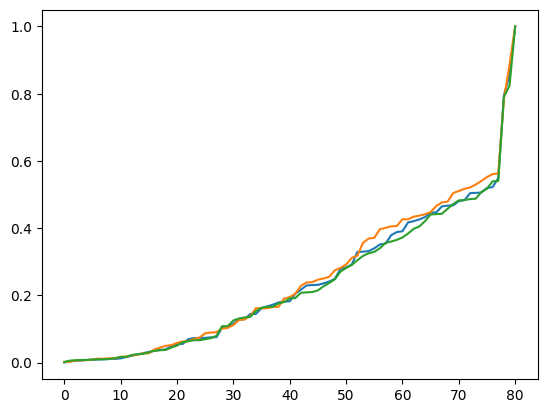

In [18]:
train_final, dev_final, test_final = analyze_annotations(new_train, new_val, new_test, crop=True)

---------- check ----------
sizes - train: (72,) val: (72,) test: (72,)
(0, 0) (0, 0) (0, 0)
set()
---------- clean ----------
(146574, 37) (18160, 37) (18233, 37)
---------- train ----------
annotator head
rater_id
71     88
64     99
13    132
58    161
29    196
Name: text, dtype: int64
annotator tail
rater_id
62    4130
2     4348
61    4748
4     4748
37    4748
Name: text, dtype: int64
ANNOTATORS
min: 88 mean: 2035.75 median: 1828.0 max: 4748 all: 146574
TEXTS
min: 1 mean: 3.3936236715982497 median: 3.0 max: 45 all: 146574
---------- dev ----------
annotator head
rater_id
71    12
64    12
13    16
48    20
58    22
Name: text, dtype: int64
annotator tail
rater_id
52    527
2     529
4     564
61    564
37    564
Name: text, dtype: int64
ANNOTATORS
min: 12 mean: 252.22222222222223 median: 228.5 max: 564 all: 18160
TEXTS
min: 1 mean: 3.377347963548447 median: 3.0 max: 9 all: 18160
---------- test ----------
annotator head
rater_id
64    13
71    17
13    17
58    23
25    25
Name:

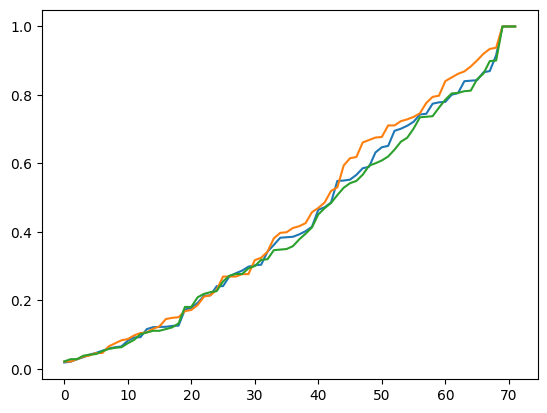

In [19]:
_ = analyze_annotations(train_final, dev_final, test_final, crop=False)

In [20]:
# train_final.to_csv(train_final_path, index=False)
# dev_final.to_csv(val_final_path, index=False)
# test_final.to_csv(test_final_path, index=False)